In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.ticker as ticker
import statsmodels.api as sm 
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA #model
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.stats.stattools import durbin_watson #DW test
from statsmodels.graphics.api import qqplot #qq test

import itertools

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [24]:
#path = "/content/drive/My Drive/Python/OilProduction/37145_Prod_noNAN.csv"
path = "/content/drive/My Drive/Python/OilProduction/Revision/data/"
# file = "import/Wilson_Prod.csv"
# df1 = pd.read_csv(path+file,
#                 #  na_values=[' ',0],
#                  usecols=['API','Date','oil/day'])
# #df1['Date']=pd.to_datetime(df1['Date'])
# #df1.set_index('Date',inplace=True)
# df1


In [59]:
df1 = df1[df1['oil/day']!= '#VALUE!']
df1['oil/day'] = df1['oil/day'].astype(float)

df1['Date']=pd.to_datetime(df1['Date'])
df1['API']=df1['API'].astype(str)
# cut_off = 10 #if oil rate is lower than 10 bbl/day, then not use
# df1 = df1[(df1['oil/day'] > cut_off)]
df1

,API,oil/day,Date
1,5123454310000,631.60,2018-09-01
2,5123454310000,583.87,2018-10-01
3,5123454310000,504.23,2018-11-01
4,5123454310000,423.29,2018-12-01
5,5123454310000,351.84,2019-01-01
...,...,...,...
943,5123454320000,97.55,2021-08-01
944,5123454320000,93.70,2021-09-01
945,5123454320000,92.65,2021-10-01
946,5123454320000,92.40,2021-11-01


In [60]:
Gobbler_API = np.unique(df1['API'])
Gobbler_API

array(['5123454260000', '5123454270000', '5123454280000', '5123454290000',
       '5123454300000', '5123454310000', '5123454320000', '5123454330000',
       '5123454340000', '5123454350000', '5123454360000', '5123454370000',
       '5123454380000', '5123454390000', '5123454400000', '5123454410000',
       '5123454420000', '5123454430000', '5123454440000', '5123454460000',
       '5123454470100', '5123454480000', '5123454490000', '5123454500000',
       '5123454510000', '5123454520000', '5123454530000', '5123454540000',
       '5123454580000'], dtype=object)

In [61]:
grouped = df1.groupby(df1['API'])
total_wells = len(Gobbler_API)
for i in range(total_wells):
    temp = grouped.get_group(str(Gobbler_API[i]))
    df = temp[['Date','oil/day']]
    df.set_index('Date',inplace=True)
    # df.to_csv(path+'prod_df/Wilson/'+str(Gobbler_API[i])+'.csv')

In [62]:
# grouped = df1.groupby(df1['API'])
# a = grouped.get_group('5123359990000')
# df_a = a[['Date','oil/day']]
# df_a.set_index('Date',inplace=True)
# df_a

KeyError: ignored

# ARIMA test for each well in each group

## Gobbler

In [22]:
from glob import glob

In [25]:
filenames = glob(path+'prod_df/Gobbler/'+'*.csv')
print (filenames[0])
# df = pd.read_csv(filenames[0])
# df_a = df[['Date','oil/day']]
# df_a.set_index('Date',inplace=True)
# print (df_a)

/content/drive/My Drive/Python/OilProduction/Revision/data/prod_df/Gobbler/5123359990000.csv


In [84]:
for filename in filenames[:1]:
    print (filename)
    print (filename[-17:-4])
    # df = pd.read_csv(filename)

/content/drive/My Drive/Python/OilProduction/Revision/data/prod_df/Gobbler/5123359990000.csv
5123359990000


#### function defination

In [59]:
from statsmodels.tsa.stattools import adfuller

def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def test_stationarity(timeseries):
    #Determing rolling statistics
    #计算移动平均，窗口大小为12 
    rolmean = timeseries.rolling(12).mean()
    #计算移动标准差，窗口大小为12
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts.values[-i])
        # print(last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果

In [27]:
# df_b = pd.DataFrame()
# print(df_b)
# dict = {'First Name': 'Vikram', 'Last Name': 'Aruchamy', 'Country': 'India'}
# df_b = df_b.append(dict, ignore_index = True)
# df_b

##continue

In [71]:
from pandas import to_datetime
from pandas import DataFrame
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

md_dict,xt_dict,yt_dict,zt_dict = {}, {}, {}, {}
dict = {'group':[],'well_name':[],
        'train_r2':[],'train_mae':[],'train_rmse':[],
        'test_r2':[],'test_mae':[],'test_rmse':[]}
df_result = pd.DataFrame(dict)

for filename in filenames: #[:1]
    df = pd.read_csv(filename)
    well = str(filename[-17:-4])
    #filename: '/content/drive/My Drive/Python/OilProduction/Revision/data/prod_df/Gobbler/5123359990000.csv'
    df_a = df[['Date','oil/day']]
    df_a['Date']=pd.to_datetime(df_a['Date'])
    df_a.set_index('Date',inplace=True)

    ts=df_a['oil/day']
    train_size = int(0.7*len(df_a['oil/day']))
    test_size = len(df_a['oil/day']) - train_size
    
    ts_log = np.log(df_a['oil/day'])
    ts_log_diff = diff_ts(ts_log[:train_size], d=[1])#调用差分方法，方便后续还原
    model = ARIMA(ts_log[:train_size], order=(0, 1, 1))  #model, (0, 1, 1), r2=0.89
    results_ARIMA = model.fit(disp=-1)  #fit
    predict_ts = results_ARIMA.predict() #对训练数据进行预测
    #restore
    diff_recover_ts = predict_diff_recover(predict_ts, d=[1])#恢复数据
    log_recover = np.exp(diff_recover_ts)#还原对数前数据
    ts_org = ts[log_recover.index]#排除空的数据
    # print(diff_recover_ts)
    # tmp_data = predict_ts
    # for i in range(1):
    #     print (i)
    #     tmp_data = tmp_data.add(shift_ts_list[-i-1])
    # print (tmp_data)
    # # ts = ts[log_recover.index]
    # # print(diff_recover_ts)  

    forecast_ARIMA_log = results_ARIMA.forecast(test_size)
    forecast_ARIMA_log = forecast_ARIMA_log[0]
    forecast_ARIMA = np.exp(forecast_ARIMA_log)

    future=df['Date'][train_size:]
    future = DataFrame(future).reset_index(drop=True)
    future.columns = ['Date']
    future['Date']= to_datetime(future['Date'])
    new_index=future['Date']
    forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
    forecast_ARIMA = np.exp(forecast_ARIMA_log)
    #print (forecast_ARIMA)

    # print('train mae: %.2f' % mean_absolute_error(log_recover,ts_org))
    # print('train R square: %.2f'% r2_score(log_recover,ts_org))#
    # print('train RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts_org)))

    # print('test mae: %.2f' % mean_absolute_error(forecast_ARIMA,df['oil/day'][train_size:]))
    # print('test R square: %.2f'% r2_score(forecast_ARIMA,df['oil/day'][train_size:]))#
    # print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,df['oil/day'][train_size:])))
 
    dict = {'group':'Gobbler',
           'well_name': well, 
           'train_r2':'%.2f'% r2_score(log_recover,ts_org),
           'train_mae':'%.2f'% mean_absolute_error(log_recover,ts_org),
           'train_rmse':'%.2f'% np.sqrt(mean_squared_error(log_recover,ts_org)),
           'test_r2': '%.2f'% r2_score(forecast_ARIMA,df['oil/day'][train_size:]),
           'test_mae': '%.2f'% mean_absolute_error(forecast_ARIMA,df['oil/day'][train_size:]),
           'test_rmse':'%.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,df['oil/day'][train_size:]))}
    df_result = df_result.append(dict, ignore_index = True)
df_result.to_csv(path+'/export/Gobbler_13wells_ARIMA.csv',index=False)
print(df_result)

      group      well_name train_r2 train_mae train_rmse test_r2 test_mae  \
0   Gobbler  5123359990000     0.72     12.06      26.51  -19.61     6.11   
1   Gobbler  5123368110000     0.88     10.12      26.81   -0.43     3.60   
2   Gobbler  5123360000000     0.70     13.04      31.12   -5.52     4.11   
3   Gobbler  5123368100000     0.94      6.94      14.26   -5.57     6.47   
4   Gobbler  5123366910000     0.78     11.88      36.44   -0.84     3.17   
5   Gobbler  5123368170000     0.94      7.32      17.40   -6.67     2.08   
6   Gobbler  5123366920000     0.86     12.54      29.56   -1.05     4.59   
7   Gobbler  5123368120000     0.91      9.49      22.33  -35.14    12.43   
8   Gobbler  5123368140000     0.83     12.64      25.12   -3.37     8.67   
9   Gobbler  5123360010000     0.66     15.77      36.14  -13.08     7.52   
10  Gobbler  5123368160000     0.93      7.31      14.26  -13.27     7.89   
11  Gobbler  5123368180000     0.77     10.54      23.12   -9.32     5.25   

In [110]:
filenames_CritterCreek = glob(path+'prod_df/CritterCreek/'+'*.csv')
from pandas import to_datetime
from pandas import DataFrame
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

md_dict,xt_dict,yt_dict,zt_dict = {}, {}, {}, {}
dict = {'group':[],'well_name':[],
        'train_r2':[],'train_mae':[],'train_rmse':[],
        'test_r2':[],'test_mae':[],'test_rmse':[]}
df_result = pd.DataFrame(dict)

for filename in filenames_CritterCreek: 
    df = pd.read_csv(filename)
    well = str(filename[-17:-4])
    print (well)
    df_a = df[['Date','oil/day']]
    df_a['Date']=pd.to_datetime(df_a['Date'])
    df_a.set_index('Date',inplace=True)

    ts=df_a['oil/day']
    train_size = int(0.7*len(df_a['oil/day']))
    test_size = len(df_a['oil/day']) - train_size
    
    ts_log = np.log(df_a['oil/day'])
    ts_log_diff = diff_ts(ts_log[:train_size], d=[1])#调用差分方法，方便后续还原
    model = ARIMA(ts_log[:train_size], order=(0, 1, 1))  #model, (0, 1, 1), r2=0.89
    results_ARIMA = model.fit(disp=-1)  #fit
    predict_ts = results_ARIMA.predict() #对训练数据进行预测
    #restore
    diff_recover_ts = predict_diff_recover(predict_ts, d=[1])#恢复数据
    log_recover = np.exp(diff_recover_ts)#还原对数前数据
    print (len(log_recover))
    ts_org = ts[log_recover.index]#排除空的数据
    print (len(ts_org))
    
    forecast_ARIMA_log = results_ARIMA.forecast(test_size)
    forecast_ARIMA_log = forecast_ARIMA_log[0]
    forecast_ARIMA = np.exp(forecast_ARIMA_log)

    future=df['Date'][train_size:]
    future = DataFrame(future).reset_index(drop=True)
    future.columns = ['Date']
    future['Date']= to_datetime(future['Date'])
    new_index=future['Date']
    forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
    forecast_ARIMA = np.exp(forecast_ARIMA_log)
    dict = {'group':'CritterCreek',
           'well_name': well, 
           'train_r2':'%.2f'% r2_score(log_recover,ts[log_recover.index]),
           'train_mae':'%.2f'% mean_absolute_error(log_recover,ts_org),
           'train_rmse':'%.2f'% np.sqrt(mean_squared_error(log_recover,ts_org)),
           'test_r2': '%.2f'% r2_score(forecast_ARIMA,df['oil/day'][train_size:]),
           'test_mae': '%.2f'% mean_absolute_error(forecast_ARIMA,df['oil/day'][train_size:]),
           'test_rmse':'%.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,df['oil/day'][train_size:]))}
    df_result = df_result.append(dict, ignore_index = True)
df_result.to_csv(path+'/export/CritterCreek_20wells_ARIMA.csv',index=False)
print(df_result)

5123459560000
19
19
5123459590200
19
19
5123459600000
19
19
5123472950000
20
20
5123472980000
20
20
5123473050000
20
20
5123473060000
20
20
5123473080000
20
20
5123473110000
20
20
5123477580000
19
19
5123477600000
19
19
5123477620100
18
18
5123477630000
19
19
           group      well_name train_r2 train_mae train_rmse  test_r2  \
0   CritterCreek  5123459560000    -1.18     17.33      33.15    -8.87   
1   CritterCreek  5123459590200     0.59     13.23      21.20    -3.34   
2   CritterCreek  5123459600000     0.75     18.20      32.90    -0.46   
3   CritterCreek  5123472950000     0.02    237.30     614.78    -1.17   
4   CritterCreek  5123472980000     0.48     50.12      72.57   -12.51   
5   CritterCreek  5123473050000     0.89     26.73      45.01     0.78   
6   CritterCreek  5123473060000    -7.83     48.51      63.80  -287.02   
7   CritterCreek  5123473080000     0.79     25.31      41.87     0.41   
8   CritterCreek  5123473110000     0.82     27.04      44.63     0.00   


## 6N

In [15]:
path_6N = "/content/drive/My Drive/Python/OilProduction/6N/6N_Prod.csv"
df_6N = pd.read_csv(path_6N,
                #  na_values=[' ',0],
                 usecols=['FirstOfMonth','OilProduced(bbl/day)'])
df_6N['FirstOfMonth']=pd.to_datetime(df_6N['FirstOfMonth'])
df_6N.set_index('FirstOfMonth',inplace=True)
df_6N

,OilProduced(bbl/day)
FirstOfMonth,
2013-09-01,347
2013-10-01,453
2013-11-01,332
2013-12-01,261
2014-01-01,215
...,...
2020-05-01,9
2020-06-01,9
2020-07-01,9


In [49]:
total_month = len(df_a['oil/day'])
train_size = int(total_month*0.7)
test_size = total_month - train_size
print (total_month, train_size, test_size)

98 68 30


In [16]:
ts_6N=df_6N['OilProduced(bbl/day)']
ts_6N_log = np.log(ts_6N)
ts_6N_log_diff=ts_6N_log.diff(1).dropna()

In [54]:
from statsmodels.tsa.arima_model import ARIMA

ts_6N_log_diff = diff_ts(ts_6N_log[:60], d=[1])#调用差分方法，方便后续还原
model_6N = ARIMA(ts_6N_log[:60], order=(0, 1, 1))  #model, (0, 1, 1), r2=0.89
results_6N_ARIMA = model_6N.fit(disp=-1)  #fit
predict_ts_6N = results_6N_ARIMA.predict() #对训练数据进行预测
#restore
tmp_data = predict_ts_6N
for i in range(1):
    print (i)
    tmp_data = tmp_data.add(shift_ts_list[-i-1])
    tmp_data.dropna(inplace=True)
    print(tmp_data)
    # try:
    #     tmp_data = tmp_data.add(shift_ts_list[-i-1])
    #     tmp_data.dropna(inplace=True)

# diff_recover_ts_6N = predict_diff_recover(predict_ts_6N, d=[1])#恢复数据
# if isinstance(predict_ts_6N, np.ndarray):
#     print ('TRUE')
#     tmp_data = predict_ts_6N
# else:
#     print('false')
#     print(type(predict_ts_6N))

# def predict_diff_recover(predict_value, d):
#     if isinstance(predict_value, float):
#         tmp_data = predict_value
#         for i in range(len(d)):
#             tmp_data = tmp_data + last_data_shift_list[-i-1]
#     elif isinstance(predict_value, np.ndarray):
#         tmp_data = predict_value[0]
#         for i in range(len(d)):
#             tmp_data = tmp_data + last_data_shift_list[-i-1]
      # else:
      #         tmp_data = predict_value
      #         for i in range(len(d)):
      #             try:
      #                 tmp_data = tmp_data.add(shift_ts_list[-i-1])
      #             except:
      #                 raise ValueError('What you input is not pd.Series type!')
      #         tmp_data.dropna(inplace=True)
      #     return tmp_data # return 
# predict_ts_6N
# log_recover_6N = np.exp(diff_recover_ts_6N)#还原对数前数据
# print (type(predict_ts_6N))

# #绘图
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# ts_6N_org = ts_6N[log_recover_6N.index]#排除空的数据
# # plt.figure(figsize=(12,8))

# plt.plot(df_6N['OilProduced(bbl/day)'],'.',color='black', label='Actual production')
# plt.plot(log_recover_6N,'*',label='Training Data Matched')
# plt.legend(loc='best',fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Oil Production: Actual VS. Predicted',fontsize=15)

# # 'RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))#RMSE,残差平方和开根号，即标准差， (sp.mean((log_recover-ts) ** 2))
# from sklearn.metrics import r2_score, mean_squared_error
# print('R square: %.2f'% r2_score(ts_6N_org,log_recover_6N))#
# print('RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover_6N,ts_6N_org)))
# print('MAE: %.2f'% mean_absolute_error(log_recover_6N,ts_6N_org))

# r2_score(y_true, y_pred)

0
2013-10-01    5.789681
2013-11-01    5.975278
2013-12-01    5.790496
2014-01-01    5.564909
2014-02-01    5.362619
2014-03-01    5.136431
2014-04-01    4.969587
2014-05-01    4.823626
2014-06-01    4.666856
2014-07-01    4.576459
2014-08-01    4.468648
2014-09-01    4.372433
2014-10-01    4.262590
2014-11-01    4.192597
2014-12-01    4.084887
2015-01-01    3.994525
2015-02-01    3.903102
2015-03-01    3.850008
2015-04-01    3.821065
2015-05-01    3.734345
2015-06-01    3.677142
2015-07-01    3.588454
2015-08-01    3.483218
2015-09-01    3.476536
2015-10-01    3.408962
2015-11-01    3.391005
2015-12-01    3.362921
2016-01-01    2.956305
2016-02-01    3.223326
2016-03-01    3.189213
2016-04-01    3.207858
2016-05-01    3.126330
2016-06-01    3.040776
2016-07-01    3.018041
2016-08-01    3.239732
2016-09-01    3.164775
2016-10-01    2.943348
2016-11-01    3.024789
2016-12-01    2.824480
2017-01-01    2.679347
2017-02-01    2.535706
2017-03-01    2.497534
2017-04-01    2.541805
2017-05-0

# Predict

In [55]:
forecast_n = test_size #forecast the 25 months' prod
forecast_ARIMA_log = results_ARIMA.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]
print (forecast_ARIMA_log)

[2.31993606 2.27764811 2.23536016 2.19307221 2.15078426 2.10849631
 2.06620835 2.0239204  1.98163245 1.9393445  1.89705655 1.8547686
 1.81248065 1.7701927  1.72790474 1.68561679 1.64332884 1.60104089
 1.55875294 1.51646499 1.47417704 1.43188909 1.38960114 1.34731318
 1.30502523 1.26273728 1.22044933 1.17816138 1.13587343 1.09358548]


In [56]:
# new_index = get_date_range('1961-01-01', forecast_n)
# new_index = range(48, 48+forecast_n)

from pandas import to_datetime
from pandas import DataFrame

future=a['Date'][train_size:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['Date']
future['Date']= to_datetime(future['Date'])
new_index=future['Date']

forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
print (forecast_ARIMA_log)

Date
2019-06-01    2.319936
2019-07-01    2.277648
2019-08-01    2.235360
2019-09-01    2.193072
2019-10-01    2.150784
2019-11-01    2.108496
2019-12-01    2.066208
2020-01-01    2.023920
2020-02-01    1.981632
2020-03-01    1.939345
2020-04-01    1.897057
2020-05-01    1.854769
2020-06-01    1.812481
2020-07-01    1.770193
2020-08-01    1.727905
2020-09-01    1.685617
2020-10-01    1.643329
2020-12-01    1.601041
2021-01-01    1.558753
2021-02-01    1.516465
2021-03-01    1.474177
2021-04-01    1.431889
2021-05-01    1.389601
2021-06-01    1.347313
2021-07-01    1.305025
2021-08-01    1.262737
2021-09-01    1.220449
2021-10-01    1.178161
2021-11-01    1.135873
2021-12-01    1.093585
dtype: float64


Date
2019-06-01    10.175024
2019-07-01     9.753714
2019-08-01     9.349849
2019-09-01     8.962706
2019-10-01     8.591594
2019-11-01     8.235848
2019-12-01     7.894832
2020-01-01     7.567936
2020-02-01     7.254576
2020-03-01     6.954191
2020-04-01     6.666244
2020-05-01     6.390219
2020-06-01     6.125624
2020-07-01     5.871985
2020-08-01     5.628848
2020-09-01     5.395778
2020-10-01     5.172359
2020-12-01     4.958191
2021-01-01     4.752890
2021-02-01     4.556091
2021-03-01     4.367440
2021-04-01     4.186601
2021-05-01     4.013249
2021-06-01     3.847075
2021-07-01     3.687782
2021-08-01     3.535085
2021-09-01     3.388710
2021-10-01     3.248396
2021-11-01     3.113892
2021-12-01     2.984957
dtype: float64


Text(0.5, 1.0, 'forecast')

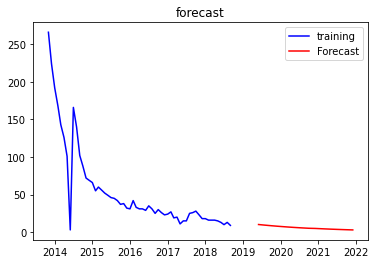

In [57]:
# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print (forecast_ARIMA)
plt.plot(ts,label='training',color='blue')
plt.plot(forecast_ARIMA, label='Forecast',color='red')
plt.legend(loc='best')
plt.title('forecast')

In [58]:
# plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts[log_recover.index]#remove empty data
plt.figure(figsize=(10,7))

plt.plot(df1['OilProduced'],'.',color='black', label='Actual Production')
plt.plot(log_recover,'-',color='gray',label='Training Data Matched')
plt.plot(forecast_ARIMA,'-',label='Test Data Predicted')
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)

# ax = plt.axes()
# ax.set_ylim(0,1000)

plt.title('Oil Production: Actual VS. Predicted (ARIMA)',fontsize=15)

KeyError: ignored

<Figure size 720x504 with 0 Axes>

In [ ]:
print('train mae: %.2f' % mean_absolute_error(log_recover,ts))
print('train R square: %.2f'% r2_score(log_recover,ts))#
print('train RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))

print('test mae: %.2f' % mean_absolute_error(forecast_ARIMA,a['oil/day'][train_size:]))
print('test R square: %.2f'% r2_score(forecast_ARIMA,a['oil/day'][train_size:]))#
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,a['oil/day'][train_size:])))

NameError: ignored

In [ ]:
# only predict one year
print('test 1-year mae: %.2f' % mean_absolute_error(forecast_ARIMA[:12],df1['OilProduced'][58:70]))
print('test R square: %.2f'% r2_score(forecast_ARIMA[:12],df1['OilProduced'][58:70]))#
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA[:12],df1['OilProduced'][58:70])))

test 1-year mae: 42.50
test R square: -0.32
test RMSE: 47.07


Order (1,1,2):
mae: 75.74
R square: -1.02
RMSE: 90.48

Order (0,1,1):
mae: 79.09
R square: -1.28
RMSE: 93.00

# others

构建模型和预测

In [ ]:
train_log_diff=ts_log_diff[:48]
test_log_diff=ts_log_diff[48:]

train_log=ts_log[:48]
test_log=ts_log[48:]

train=ts[:48]
test=ts[48:]

train_log

0     9.028699
1     9.165970
2     8.802973
3     8.507345
4     8.255569
5     8.159375
6     8.012018
7     7.566828
8     7.875119
9     7.664347
10    7.603399
11    7.435438
12    7.382746
13    7.210080
14    7.176255
15    7.142827
16    6.873164
17    6.954639
18    6.845880
19    6.815640
20    6.668228
21    6.612041
22    6.484635
23    6.558198
24    6.517671
25    6.450470
26    6.505784
27    6.749931
28    6.502790
29    6.453625
30    6.458338
31    6.423247
32    6.257668
33    6.375025
34    6.366470
35    5.932245
36    6.577861
37    6.395262
38    6.428105
39    6.354370
40    6.073045
41    6.327937
42    6.066108
43    5.849325
44    5.488938
45    5.468060
46    6.212606
47    5.973810
Name: OilProduced, dtype: float64

Text(0.5, 1.0, 'RSS:2.09')

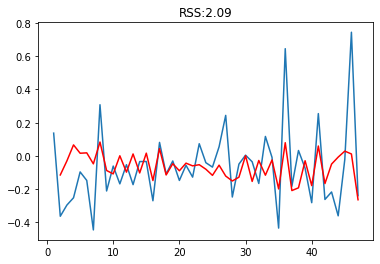

In [ ]:
model = ARIMA(train_log,(1,1,2)).fit(disp=-1)#第二个参数代表使用了一阶差分

plt.plot(train_log_diff)
plt.plot(model.predict(), color='red') #红色线代表预测值
plt.title('RSS:%.2f' % sum((model.fittedvalues-train_log_diff)**2))#残差平方和   #when using ts_log_diff, RSS=4.94, (0,1,3); RSS=5.02,(0,1,2);

In [ ]:
model.predict()

2    -0.114402
3    -0.029855
4     0.066556
5     0.016296
6     0.018646
7    -0.047491
8     0.083714
9    -0.087594
10   -0.107948
11    0.001020
12   -0.097548
13    0.011971
14   -0.102382
15    0.016813
16   -0.148006
17    0.044113
18   -0.114337
19   -0.046661
20   -0.089238
21   -0.043341
22   -0.059670
23   -0.052662
24   -0.079833
25   -0.116813
26   -0.055422
27   -0.120958
28   -0.150712
29   -0.127819
30    0.001540
31   -0.153207
32   -0.027313
33   -0.115862
34   -0.024170
35   -0.198407
36    0.079693
37   -0.208407
38   -0.191831
39   -0.028826
40   -0.178554
41    0.059726
42   -0.166142
43   -0.048928
44   -0.006936
45    0.029008
46    0.011931
47   -0.263697
dtype: float64

D-W检验值为1.9903724910377139


<Figure size 864x576 with 0 Axes>

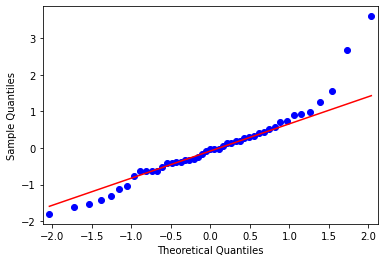

In [ ]:
#残差
resid = model.resid 
#利用QQ图检验残差是否满足正态分布
plt.figure(figsize=(12,8))
qqplot(resid,line='q',fit=True)
#利用D-W检验,检验残差的自相关性
print('D-W检验值为{}'.format(durbin_watson(resid.values)))

# 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
#  D-W检验如何数学说明，可以参考下面链接。
#  https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html

Prediction

In [ ]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print last_data_shift_list
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts


# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果


In [ ]:
train_log_restored = pd.Series([train_log[0]], index=[train_log.index[0]]) .append(model.predict()).cumsum()
train_log_restored                              

0     9.028699
2     8.905538
3     8.895166
4     8.975153
5     8.991626
6     8.930652
7     8.834455
8     8.867216
9     8.718075
10    8.580371
11    8.549108
12    8.509615
13    8.473359
14    8.425244
15    8.361559
16    8.256223
17    8.244815
18    8.166026
19    8.069073
20    8.001623
21    7.950527
22    7.905290
23    7.850137
24    7.746127
25    7.632241
26    7.571710
27    7.476256
28    7.298069
29    7.252535
30    7.261503
31    7.182668
32    7.101265
33    7.058519
34    6.954195
35    6.826851
36    6.887425
37    6.669592
38    6.485148
39    6.463045
40    6.404542
41    6.459948
42    6.333566
43    6.251668
44    6.280601
45    6.325651
46    6.282745
47    5.881109
dtype: float64

Text(0.5, 1.0, 'RMSE: 2285.7162')

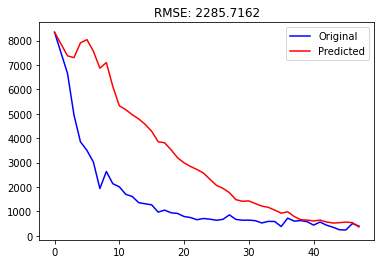

In [ ]:
# 还原
log_recover = np.exp(train_log_restored)#还原对数前数据

#绘图
ts = ts[log_recover.index]#排除空的数据
plt.plot(ts,color="blue",label='Original')
plt.plot(log_recover,color='red',label='Predicted')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/len(ts)))#RMSE,残差平方和开根号，即标准差

In [ ]:
forecast_n = 36 #预测未来36个月走势
forecast_ARIMA_log = model.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]
print (forecast_ARIMA_log)

[5.7809346  5.86243267 5.82906968 5.76257987 5.69609006 5.62960026
 5.56311045 5.49662065 5.43013084 5.36364104 5.29715123 5.23066143
 5.16417162 5.09768182 5.03119201 4.9647022  4.8982124  4.83172259
 4.76523279 4.69874298 4.63225318 4.56576337 4.49927357 4.43278376
 4.36629396 4.29980415 4.23331434 4.16682454 4.10033473 4.03384493
 3.96735512 3.90086532 3.83437551 3.76788571 3.7013959  3.6349061 ]


48    5.780935
49    5.862433
50    5.829070
51    5.762580
52    5.696090
dtype: float64
48    324.061916
49    351.578378
50    340.042182
51    318.168103
52    297.701130
53    278.550747
54    260.632262
55    243.866428
56    228.179099
57    213.500898
58    199.766909
59    186.916394
60    174.892521
61    163.642115
62    153.115419
63    143.265880
64    134.049938
65    125.426834
66    117.358434
67    109.809054
68    102.745307
69     96.135954
70     89.951764
71     84.165387
72     78.751235
73     73.685361
74     68.945363
75     64.510277
76     60.360489
77     56.477647
78     52.844578
79     49.445216
80     46.264527
81     43.288444
82     40.503804
83     37.898294
dtype: float64


Text(0.5, 1.0, 'forecast')

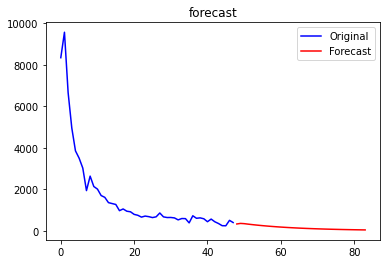

In [ ]:
# 预测从1961-01-01开始，也就是我们训练数据最后一个数据的后一个日期
# new_index = get_date_range('1961-01-01', forecast_n)
new_index = range(48, 48+forecast_n)
forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
print (forecast_ARIMA_log.head())

# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print (forecast_ARIMA)
plt.plot(train,label='Original',color='blue')
plt.plot(forecast_ARIMA, label='Forecast',color='red')
plt.legend(loc='best')
plt.title('forecast')

Text(0.5, 1.0, 'Comparison')

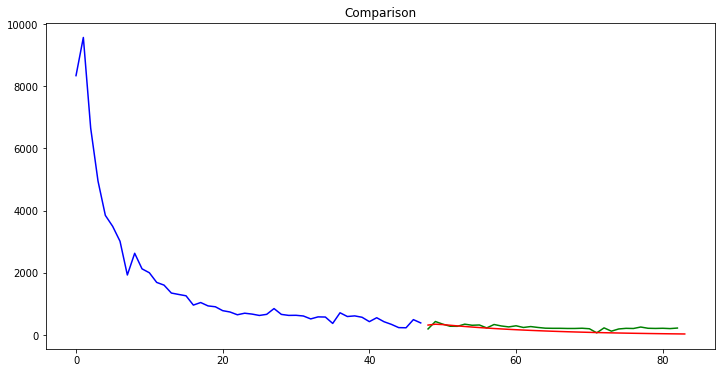

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train,color="blue") # 画出原来的时间序列图
plt.plot(test,color="green") # 画出原来的时间序列图
plt.plot(forecast_ARIMA, label='Forecast',color='red') # 画出原来的时间序列图


# plt.plot(test['pred'],color='red',linestyle='-.')# 画出预测的时间序列
plt.title("Comparison")

In [ ]:
# 一次一阶差分的恢复
import pandas as pd
time_series = pd.Series([2,4,3,5,6,7,4,5,6,3,2,4], index=pd.date_range(start='2000', periods=12, freq='a'))
time_series_diff = time_series.diff(1).dropna()

time_series_restored = pd.Series([time_series[0]], 
                                 index=[time_series.index[0]]) .append(time_series_diff).cumsum()

time_series.index[0]

Timestamp('2000-12-31 00:00:00', freq='A-DEC')

In [ ]:
time_series

2000-12-31    2
2001-12-31    4
2002-12-31    3
2003-12-31    5
2004-12-31    6
2005-12-31    7
2006-12-31    4
2007-12-31    5
2008-12-31    6
2009-12-31    3
2010-12-31    2
2011-12-31    4
Freq: A-DEC, dtype: int64

In [ ]:
## (6) 将差分后的数据还原为真实数据
last = train.loc[train.shape[0]-1,]['OilProduced']
pred = []
for i in pred_diff[0]:
    pred.append(last+i)
    last = last+i
test['pred'] = pred
test

,FirstOfMonth,OilProduced,pred
40,2017-02-01,434.0,1208.704723
41,2017-03-01,560.0,1593.752904
42,2017-04-01,431.0,1861.161227
43,2017-05-01,347.0,2005.105579
44,2017-06-01,242.0,2021.486257
45,2017-07-01,237.0,1908.564374
46,2017-08-01,499.0,1665.038630
47,2017-09-01,393.0,1290.395056
48,2017-10-01,200.0,784.218044
49,2017-11-01,438.0,146.357765


确定p d q，



1.   首先要确定 d，答：看序列要不要差分后才能平稳。
2.   其次确定 AR  MA  还是ARMA ？ 答：若平稳序列的偏相关函数是截尾的，而自相关函数是拖尾的，可断定序列适合AR模型；若平稳序列的偏相关函数是拖尾的，而自相关函数是截尾的，则可断定序列适合MA模型；若平稳序列的偏相关函数和自相关函数均是拖尾的，则序列适合ARMA模型。
3.   接下来，关键在于分清托尾、截尾的概念。答：相关函数值在k>q以后全部是0，称为截尾性；如果随着滞后期k的增加，函数值呈现指数或正弦波衰减，趋于0，称为拖尾性。
4.   说白了，什么是拖尾、什么是截尾？ 答：截尾就是前面只有孤立的长长一根，后面突然全没了。拖尾就是没有截干净的，后面杂七杂吧还有。（引自论坛某位高人语录）
5.  确定AR  MA  还是ARMA 后，第三，才是确定p、q。答：看拖尾部分，有几根在可信区间外，偏自相关确定p，自相关确定q。（第三点是我自己体会，可能有错），多组合组合，根据软件计算的结果来确定模型的优劣。


Reference:

http://xtf615.com/2017/03/08/Python%E5%AE%9E%E7%8E%B0%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E5%88%86%E6%9E%90/